In [1]:
import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
import pandas as pd
from IPython.display import display, clear_output
df = pd.read_csv('./datasets/crime_and_incarceration_by_state.csv')

In [2]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter serverextension enable voila --sys-prefix

In [3]:
project_title = widgets.HTML(value="<h1>ECS 171 Project (Title Placeholder)<h1>")
group_members = widgets.HTML(value="<h2>Group Members: Names go here<h2>")
heading_vbox = widgets.VBox([project_title, group_members])
header = widgets.HBox([heading_vbox])

In [4]:
preprocessing_header = widgets.HTML(value="<h1>Dataset Preprocessing<h1>")
commentary_correlation_before = widgets.HTML(value="<h2>Dataset Feature Correlation Prior to Preprocessing<h2>")
preprocessing_header_vbox = widgets.VBox([preprocessing_header, commentary_correlation_before])
preprocessing = widgets.HBox([preprocessing_header_vbox])

In [5]:
display(header, preprocessing)


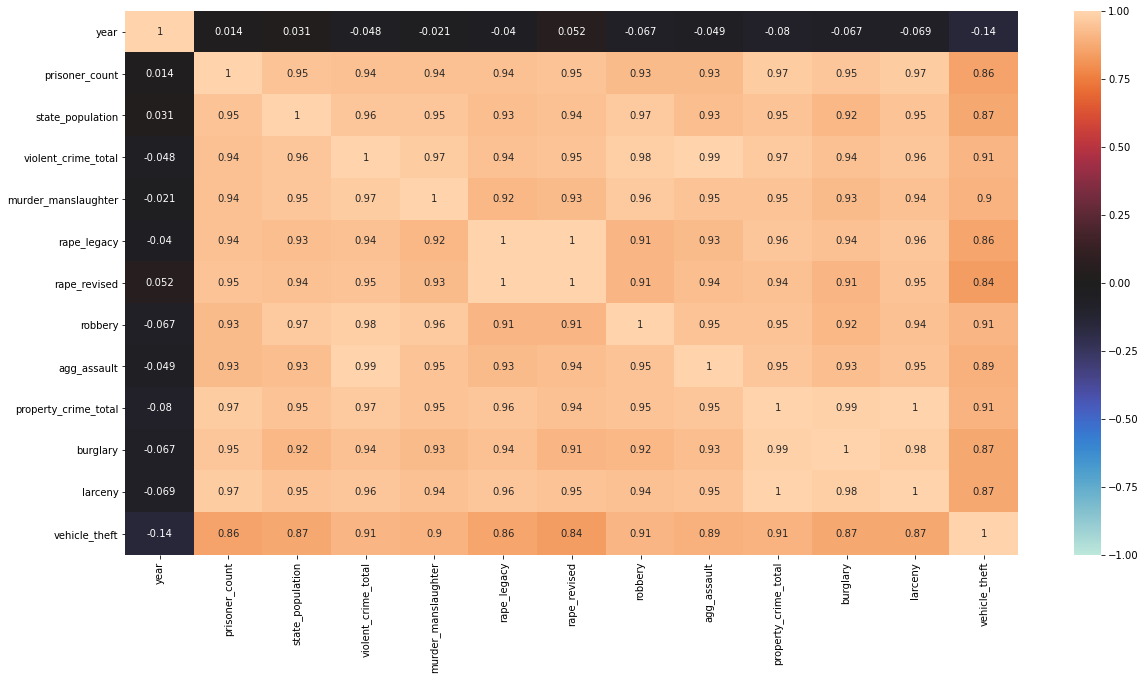

In [6]:
numerical_features = df.select_dtypes(['int64', 'float64'])

# plot correlation heatmap prior to any preprocessing
import seaborn as sns
unprocessed_dataset_corr_heatmap = sns.heatmap(numerical_features.corr(),annot=True,vmin=-1, vmax=1,center=0)
unprocessed_dataset_corr_heatmap.figure.set_size_inches(20,10)

commentary_correlation_after = widgets.HTML(value="<h2>Dataset Feature Correlation After Preprocessing<h2>")
preprocessing_footer_vbox = widgets.VBox([commentary_correlation_after])
preprocessing_footer_hbox = widgets.HBox([preprocessing_footer_vbox])

In [7]:
display(preprocessing_footer_hbox)

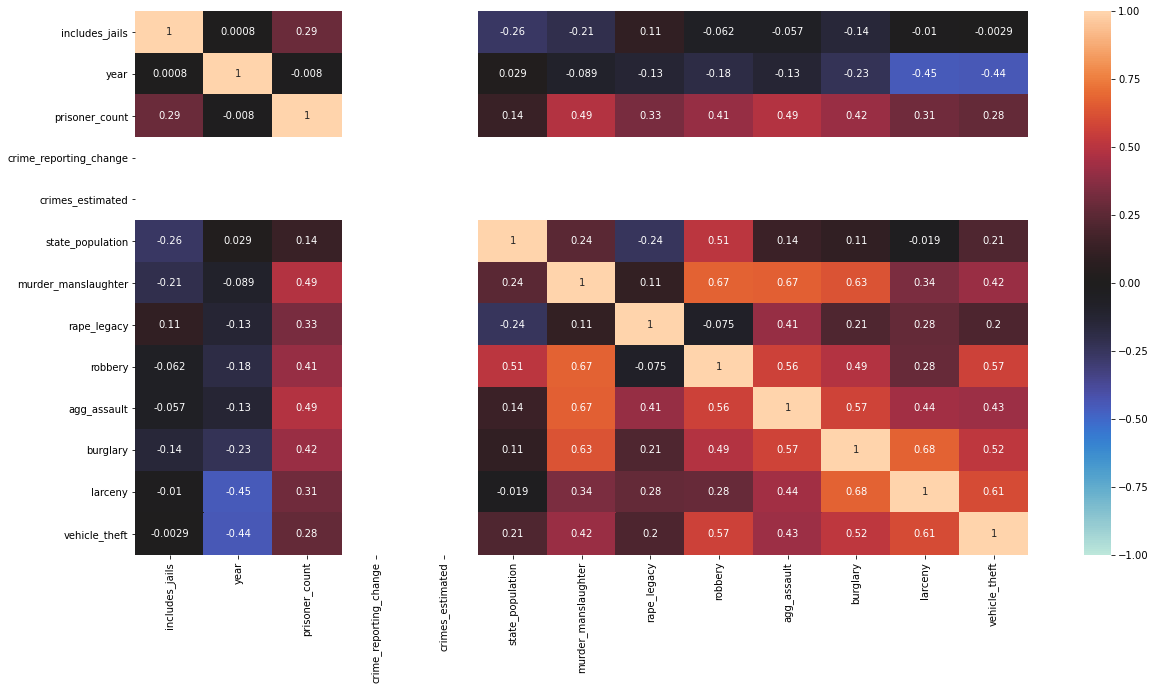

In [8]:
# Run all preprocessing steps from data management
df.drop(columns=['rape_revised'], inplace=True)

# Rows with FEDERAL jurisdiction are missing a lot of data, and we mostly care about states. So, we remove those rows.
federal_rows = df[df['jurisdiction'] == 'FEDERAL']
df.drop(federal_rows.index, inplace=True)

# removing row, but should it be removed?
df.drop(746, inplace=True)

# All remaining rows have all the data except for 50 which are missing rape_legacy. All of these rows are from 2016. 
#So, it seems relatively safe to remove these rows and restrict the model to years 2001-2015 for simplicity.
df.drop(df[df['rape_legacy'].isna()].index, inplace=True)

df_copy = df.copy() # copy of the data frame before any encoding/normalization
bar_plot_df = df_copy.copy()
regression_df = df_copy.copy()

numerical_columns = ['prisoner_count', 'violent_crime_total', 'murder_manslaughter', 'rape_legacy', 'robbery', 'agg_assault', 'property_crime_total', 'burglary', 'larceny', 'vehicle_theft']
for column in numerical_columns:
    df[column] /= df['state_population']
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Encode binary features.
df['includes_jails'] = df['includes_jails'].apply(lambda x: 1 if x else 0)

df['crime_reporting_change'] = df['crime_reporting_change'].apply(lambda x: 1 if x == 'True' else 0)
df['crimes_estimated'] = df['crimes_estimated'].apply(lambda x: 1 if x == 'True' else 0)

# one hot encode jurisdiction
df = pd.get_dummies(df, columns=['jurisdiction'])

# min-max scale population
df['state_population'] = scaler.fit_transform(df[['state_population']])

# min-max scale year
df['year'] = scaler.fit_transform(df[['year']])

# remove correlated features
df.drop(columns=['violent_crime_total', 'property_crime_total'], inplace=True)



df_poverty_rate = pd.read_csv('./datasets/poverty_rate_per_year.csv')

df_poverty_rate.rename(columns = {'DATE' : 'Year', 'PPAAUS00000A156NCEN' : 'Poverty_rate'}, inplace = True)
df_poverty_rate = df_poverty_rate.drop(labels = range(0, 12), axis = 0)
df_poverty_rate = df_poverty_rate.drop(labels = range(28, 31), axis = 0)
df_poverty_rate = df_poverty_rate.reset_index(drop = True)
df_poverty_rate['Year'] = df_poverty_rate['Year'].astype(str)
df_poverty_rate['Year'] = df_poverty_rate['Year'].str.slice(0, 4, 1)
df_poverty_rate['Year'] = df_poverty_rate['Year'].astype(int)


df_copy["poverty_rate"] = ""

df_copy.loc[df_copy['year'] == 2001, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][0]
df_copy.loc[df_copy['year'] == 2002, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][1]
df_copy.loc[df_copy['year'] == 2003, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][2]
df_copy.loc[df_copy['year'] == 2004, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][3]
df_copy.loc[df_copy['year'] == 2005, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][4]
df_copy.loc[df_copy['year'] == 2006, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][5]
df_copy.loc[df_copy['year'] == 2007, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][6]
df_copy.loc[df_copy['year'] == 2008, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][7]
df_copy.loc[df_copy['year'] == 2009, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][8]
df_copy.loc[df_copy['year'] == 2010, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][9]
df_copy.loc[df_copy['year'] == 2011, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][10]
df_copy.loc[df_copy['year'] == 2012, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][11]
df_copy.loc[df_copy['year'] == 2013, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][12]
df_copy.loc[df_copy['year'] == 2014, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][13]
df_copy.loc[df_copy['year'] == 2015, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][14]
df_copy.loc[df_copy['year'] == 2016, ['poverty_rate']] = df_poverty_rate['Poverty_rate'][15]



numerical_features = df.select_dtypes(['int64', 'float64'])
preprocessed_dataset_corr_heatmap = sns.heatmap(numerical_features.corr(),annot=True,vmin=-1, vmax=1,center=0)
preprocessed_dataset_corr_heatmap.figure.set_size_inches(20,10)



#df_state = df_copy[df_copy['jurisdiction'] == 'CALIFORNIA']
#df_state_year = df_state[df_state['year'] == 2005]
#year_state_pop = df_state_year['state_population']
#df_state_year.drop(['includes_jails','crime_reporting_change', 'crimes_estimated', 'year', 'jurisdiction', 'state_population'], axis=1, inplace=True)
#for column in df_state_year:
#    df_state_year[column] /= year_state_pop
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(20,10))
##plt.bar(['Prisoner Count', 'Violent Crime Total', 'Murder-Manslaughter', 'Rape Legacy', 'Robbery', 'Agg Assault',
#         'Propery Crime Total','Burglary', 'Larceny', 'Vehicle Theft'], df_state_year.to_numpy()[0])
#plt.xlabel('Crime Types Per Population')
#plt.show()





In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


def performPolyReg(state, predictor, predicted):
    
    df_state = regression_df[regression_df['jurisdiction'] == state]
    
    degrees = np.arange(1,11) # array of degree values to try (we want to determine degree with lowest error)

    min_rmse = 1e10 # intialize to really large number
    best_deg = 0 

    X = df_state[predictor].values.reshape(-1,1)
    Y = df_state[predicted].values.reshape(-1,1)

    for deg in degrees:
        poly_reg = PolynomialFeatures(degree = deg)
        X_poly = poly_reg.fit_transform(X.reshape(-1,1))

        # fit must be included in a linear regression model
        lin_reg = LinearRegression()
        lin_reg.fit(X_poly, Y)
        Y_poly_predict = lin_reg.predict(X_poly)

        # calculating rmse
        rmse = np.sqrt(mean_squared_error(Y, Y_poly_predict))

        # If current degree gives a smaller error
        if min_rmse > rmse:
            min_rmse = rmse
            best_deg = deg

    # Plotting polynomial regression for the best degree
    best_poly_reg = PolynomialFeatures(degree = best_deg)
    X_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, Y)
    Y_poly_predict = lin_reg.predict(X_poly)
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, color='red')
    result_plot = plt.plot(X, lin_reg.predict(poly_reg.fit_transform(X.reshape(-1,1))), color='blue')
    plt.xlabel(predictor)
    plt.ylabel(predicted)
    plt.show()
    
    

    print('Best Degree:', best_deg)
    print('RMSE:', min_rmse)
    return result_plot

dependent_variable_selection = widgets.Dropdown(
    options=['prisoner_count', 'violent_crime_total', 'murder_manslaughter', 'rape_legacy', 'robbery', 'agg_assault', 
            'property_crime_total', 'burglary', 'larceny', 'vehicle_theft', 'poverty_rate'],
    description='Dependent Variable:',
    style={'description_width':'auto'},
    disabled=False
    )

independent_variable_selection = widgets.Dropdown(
    options=['prisoner_count', 'violent_crime_total', 'murder_manslaughter', 'rape_legacy', 'robbery', 'agg_assault', 
            'property_crime_total', 'burglary', 'larceny', 'vehicle_theft', 'poverty_rate'],
    description='Independent Variable:',
    style={'description_width':'auto'},
    disabled=False
    )

regression_state_selection = widgets.Dropdown(
    options=['ALABAMA','ALASKA','ARIZONA','ARKANSAS','CALIFORNIA','COLORADO','CONNECTICUT','DELAWARE'
            ,'FLORIDA','GEORGIA','HAWAII','IDAHO','ILLINOIS','INDIANA','IOWA','KANSAS','KENTUCKY','LOUISIANA'
            ,'MAINE','MARYLAND','MASSACHUSETTS','MICHIGAN','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEBRASKA',
            'NEVADA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','OREGON'
            ,'PENNSYLVANIA','RHODE ISLAND','SOUTH CAROLINA','SOUTH DAKOTA','TENNESSEE','TEXAS','UTAH','VERMONT','VIRGINIA',
             'WASHINGTON','WEST VIRGINIA','WISCONSIN','WYOMING'],
    description='State:',
    disabled=False,
)
show_regression_plot_button = widgets.Button(
    description='Show Regression Plot',
    tooltip='Show Regression Plot',
    style={'description_width':'initial'}
)

regression_output = widgets.Output()
def show_regression_clicked(event):
    with regression_output:
        clear_output()
        out = performPolyReg(regression_state_selection.value, independent_variable_selection.value, 
                            dependent_variable_selection.value)
        display(out)
        
show_regression_plot_button.on_click(show_regression_clicked)   

regression_header = widgets.HTML(value="<h2>Regression Model<h2>")
regression_inputs_HBox = widgets.HBox([independent_variable_selection, dependent_variable_selection, regression_state_selection,
                                      show_regression_plot_button])
regression_VBox = widgets.VBox([regression_header, regression_inputs_HBox, regression_output])
display(regression_VBox)


In [10]:
def generate_bar_plot(state, year):
    df_state = bar_plot_df[bar_plot_df['jurisdiction'] == state]
    df_state_year = df_state[df_state['year'] == year]
    year_state_pop = df_state_year['state_population']
    df_state_year.drop(['includes_jails','crime_reporting_change', 'crimes_estimated', 'year',
                        'jurisdiction', 'state_population'], axis=1, inplace=True)
    for column in df_state_year:
        df_state_year[column] /= year_state_pop
    
    plt.figure(figsize=(20,10))
    plt.xlabel('Crime Types Per Population')
    temp = plt.bar(['Prisoner Count', 'Violent Crime Total', 'Murder-Manslaughter', 'Rape Legacy', 'Robbery', 'Agg Assault',
         'Propery Crime Total','Burglary', 'Larceny', 'Vehicle Theft'], df_state_year.to_numpy()[0])
    plt.show()
    return temp
    
barplot_state_selection = widgets.Dropdown(
    options=['ALABAMA','ALASKA','ARIZONA','ARKANSAS','CALIFORNIA','COLORADO','CONNECTICUT','DELAWARE'
            ,'FLORIDA','GEORGIA','HAWAII','IDAHO','ILLINOIS','INDIANA','IOWA','KANSAS','KENTUCKY','LOUISIANA'
            ,'MAINE','MARYLAND','MASSACHUSETTS','MICHIGAN','MINNESOTA','MISSISSIPPI','MISSOURI','MONTANA','NEBRASKA',
            'NEVADA','NEW HAMPSHIRE','NEW JERSEY','NEW MEXICO','NEW YORK','NORTH CAROLINA','NORTH DAKOTA','OHIO','OKLAHOMA','OREGON'
            ,'PENNSYLVANIA','RHODE ISLAND','SOUTH CAROLINA','SOUTH DAKOTA','TENNESSEE','TEXAS','UTAH','VERMONT','VIRGINIA',
             'WASHINGTON','WEST VIRGINIA','WISCONSIN','WYOMING'],
    description='State:',
    disabled=False,
)
year_selection_slider = widgets.IntSlider(
    description='Year',
    value=2001,
    min=2001,
    max=2015,
    step=1,
    style={'description_width':'initial', 'handle_color': '#16a085'}
)
show_bar_plot_data_button = widgets.Button(
    description='Show Bar Plot',
    tooltip='Show Data',
    style={'description_width':'initial'}
    
)
plot_output = widgets.Output()
def show_data_clicked(event):
    with plot_output:
        clear_output()
        out = generate_bar_plot(barplot_state_selection.value, year_selection_slider.value)
        display(out)
show_bar_plot_data_button.on_click(show_data_clicked)

bar_plot_input_HBox = widgets.HBox([barplot_state_selection, year_selection_slider, show_bar_plot_data_button])
bar_plot_header = widgets.HTML(value="<h2>Dataset Exploration (Crime Types Per Population)<h2>")
bar_plot_VBox = widgets.VBox([bar_plot_header,bar_plot_input_HBox, plot_output])
display(bar_plot_VBox)

HTML(value='<h2>Thresholds Plot (Temporary Name) Not sure if we should include this plot<h2>')

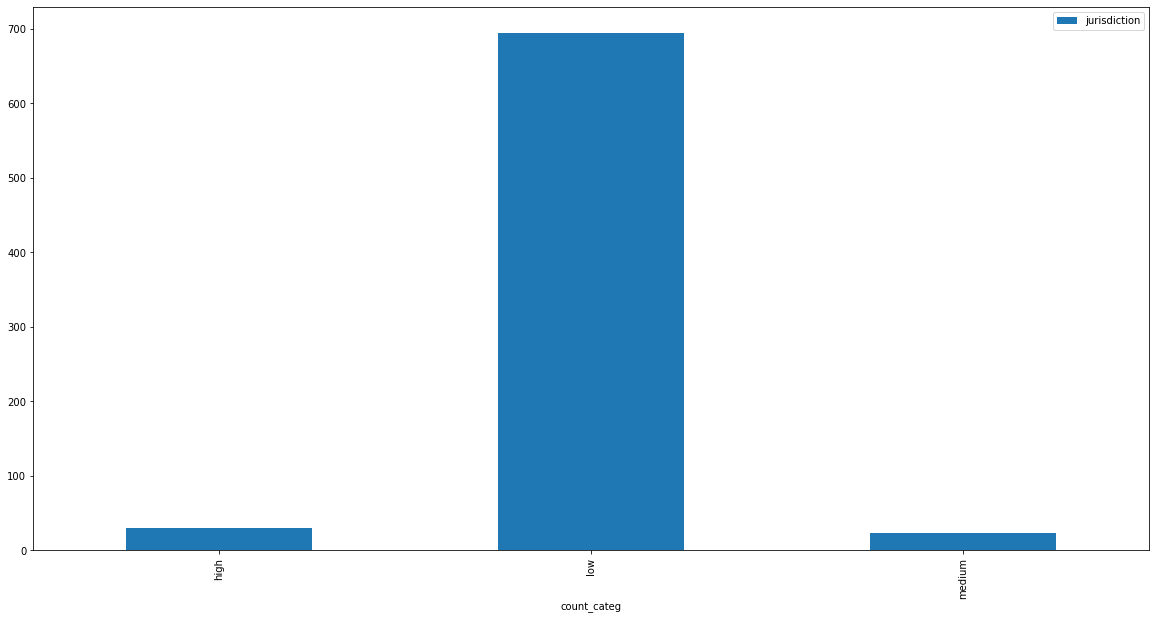

In [11]:
thresholds_header = widgets.HTML(value="<h2>Thresholds Plot (Temporary Name) Not sure if we should include this plot<h2>")
display(thresholds_header)
#Calculting Thresholds for prisoner count across states

min_wt = min(df_copy['prisoner_count'])
max_wt = max(df_copy['prisoner_count'])
per_bin = (max_wt - min_wt)/3

bin1_start = min(df_copy['prisoner_count'])
bin1_end = bin1_start + per_bin
bin2_end = bin1_end + per_bin

def label_wt(row):
    if bin1_start <= row['prisoner_count'] and row['prisoner_count'] <= bin1_end:
        return 'low'
    elif row['prisoner_count'] <= bin2_end:
        return 'medium'
    else:
        return 'high'
    
df_copy['count_categ'] = df_copy.apply(lambda row: label_wt(row),axis=1)
#print("Thresholds: \nBin 1 = ",bin1_end,"\nBin 2 = ",bin2_end,"\nBin 3 = ",max_wt,"\nSize of each bin = ",per_bin)
df_copy.groupby('count_categ').count().reset_index().plot.bar(x='count_categ',y='jurisdiction',figsize=(20,10))


#Encoding jurisdiction column using LabelEncoder
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df_copy['jurisdiction'] = LE.fit_transform(df_copy['jurisdiction'])

In [12]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
def generate_kmeans_plot(year):
    df_year = df_copy.groupby(['year']).get_group(year)
    df_population = pd.DataFrame(df_year, columns = ['jurisdiction', 'state_population'])
    kmeans = KMeans(n_clusters = 3).fit(df_population)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_population)
    
    #Using KMeans to group states by prisoner_count by year
    df_prisoner_count = pd.DataFrame(df_year, columns = ['jurisdiction', 'prisoner_count'])
    kmeans = KMeans(n_clusters = 4).fit(df_prisoner_count)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_prisoner_count)
    
    #Using KMeans to group states by high, medium, low total violent crime
    df_crime_total = pd.DataFrame(df_year, columns = ['jurisdiction', 'violent_crime_total'])
    kmeans = KMeans(n_clusters = 3).fit(df_crime_total)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_crime_total)
    
    #Using KMeans to group states by high, medium, low poverty rate
    df_poverty_rate = pd.DataFrame(df_year, columns = ['jurisdiction', 'poverty_rate'])
    kmeans = KMeans(n_clusters = 3).fit(df_poverty_rate)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_poverty_rate)
    
    df_burglary_prisoner_count = pd.DataFrame(df_year, columns = ['burglary', 'prisoner_count'])
    kmeans = KMeans(n_clusters = 3).fit(df_burglary_prisoner_count)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_burglary_prisoner_count)
    
    #Subplot of all KMeans Plots
    plt.figure(figsize = (10,10))
    plt.subplot(3, 2, 1)
    plt.scatter(df_population.jurisdiction, df_population.state_population, c = kmeans.labels_.astype(float), s=200, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.subplot(3, 2, 2)
    plt.scatter(df_prisoner_count.jurisdiction, df_prisoner_count.prisoner_count, c = kmeans.labels_.astype(float), s=200, alpha = 0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.subplot(3, 2, 3)
    plt.scatter(df_crime_total.jurisdiction, df_crime_total.violent_crime_total, c = kmeans.labels_.astype(float), s=200, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.subplot(3,2,4)
    plt.scatter(df_poverty_rate.jurisdiction, df_poverty_rate.poverty_rate, c = kmeans.labels_.astype(float), s=200, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.subplot(3,2,5)
    plt.scatter(df_burglary_prisoner_count.burglary, df_burglary_prisoner_count.prisoner_count, c = kmeans.labels_.astype(float), s=200, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.show()
    
    df_3d = pd.DataFrame(df_year, columns = ['burglary', 'violent_crime_total', 'prisoner_count'])
    kmeans = KMeans(n_clusters = 3).fit(df_3d)
    centroids = kmeans.cluster_centers_
    y_km = kmeans.fit_predict(df_3d)
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = '3d')
    ax.scatter(df_3d.burglary, df_3d.violent_crime_total, df_3d.prisoner_count, c=y_km, cmap='Set2', s=50)
    ax.set_xlabel('burglary')
    ax.set_ylabel('violent crime total')
    ax.set_zlabel('prisoner count')
    #Plotting centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], marker = '*', c='black', s=100)
    plt.show()

kmeans_year_selection_slider = widgets.IntSlider(
    description='Year',
    value=2001,
    min=2001,
    max=2015,
    step=1,
    style={'description_width':'initial', 'handle_color': '#16a085'}
)  
    
    
show_kmeans_plot_button = widgets.Button(
    description='Show K-means Plot',
    tooltip ='Show K-means Plot',
    style ={'description_width': 'auto'}
)    
    
kmeans_output = widgets.Output()
def show_kmeans_clicked(event):
    with kmeans_output:
        clear_output()
        display(generate_kmeans_plot(kmeans_year_selection_slider.value))

show_kmeans_plot_button.on_click(show_kmeans_clicked)
        

kmeans_header = widgets.HTML(value="<h2>Dataset Exploration (K-means)<h2>")


kmeans_inputs_HBox = widgets.HBox([kmeans_year_selection_slider, show_kmeans_plot_button])
kmeans_VBox = widgets.VBox([kmeans_header,kmeans_inputs_HBox])
display(kmeans_VBox, kmeans_output)

Output()